In [1]:
import tess_cpm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import lightkurve as lk

In [2]:
plt.rcParams['figure.figsize'] = (14, 8)

In [ ]:
# fits_file = "tpf/tess-s0001-4-1_64.525833_-63.615669_64x64_astrocut.fits"
fits_file = "provided_sources/tess-s0015-1-1_322.878520_47.920650_64x64_astrocut.fits"
# fits_file = "tess-s0002-4-2_83.272000_-69.508733_64x64_astrocut.fits"
# tabby14_file = "ffi/tabby/tess-s0014-2-4_301.564386_44.456886_100x100_astrocut.fits"
tabby15_file = "ffi/tabby/tess-s0015-2-3_301.564386_44.456886_100x100_astrocut.fits"
# tau_ceti_file = "ffi/tau_ceti/tess-s0003-1-2_26.017048_-15.937482_100x100_astrocut.fits"
sn_file = "supernovae/tess-s0001-4-1_64.525833_-63.615669_100x100_astrocut.fits"
fits_file = "provided_sources/tess-s0015-1-1_322.878520_47.920650_64x64_astrocut.fits" # interesting eclipsing binary

In [ ]:
tabby15 = tess_cpm.Source(tabby15_file, remove_bad=True)

In [ ]:
tabby15.plot_cutout();

In [ ]:
tabby15.set_aperture(rowlims=[49, 52], collims=[49, 52])
tabby15.plot_cutout(rowlims=[46, 55], collims=[46, 55], show_aperture=True);

In [ ]:
# tabby15.set_aperture(rowrange=[49, 52], colrange=[49, 52])
# tabby15.plot_cutout(rowrange=[47, 53], colrange=[48, 53], show_aperture=True)

In [ ]:
tabby15.plot_pix_by_pix();

In [ ]:
tabby15.add_cpm_model()
tabby15.set_regs([0.01])
times, fluxes, predictions = tabby15.holdout_fit_predict(k=50)

In [ ]:
tabby15.plot_pix_by_pix(data_type="cpm_subtracted_flux", split=True)

In [ ]:
detrended_aperture_lc = tabby15.get_aperture_lc(data_type="cpm_subtracted_flux")

In [ ]:
plt.plot(tabby15.time, detrended_aperture_lc, "-", c="k")
outliers = tess_cpm.get_outliers(detrended_aperture_lc, window=80, sigma_upper=3, sigma_lower=1.5)
plt.plot(tabby15.time[outliers], detrended_aperture_lc[outliers], "x", c="red")
plt.plot(tabby15.time[~outliers], detrended_aperture_lc[~outliers], "-", c="green")

In [ ]:
# tabby15.set_regs([0.0001])
times, fluxes, predictions = tabby15.holdout_fit_predict(k=50, mask=~outliers)

In [ ]:
tabby15.plot_pix_by_pix(data_type="cpm_subtracted_flux")

In [ ]:
with_mask_apt_lc = tabby15.get_aperture_lc(data_type="cpm_subtracted_flux")
plt.plot(tabby15.time, with_mask_apt_lc, "-", c="k")
lc = lk.TessLightCurve(time=tabby15.time, flux=with_mask_apt_lc+1)
# lc.plot()
# plt.plot(tabby15.time, lc.flatten().flux)

In [ ]:
plt.plot(tabby15.time, detrended_aperture_lc)
plt.plot(tabby15.time, with_mask_apt_lc)

In [ ]:
cpm_regs = 10.0 ** np.arange(-6, 6)
min_reg, cdpps = tabby15.calc_min_cpm_reg(cpm_regs, k=50)
print(f"Min CDPP Reg: {min_reg}")

In [ ]:
tabby15.set_regs([min_reg])
tabby15.holdout_fit_predict(k=5)
detrended_apt_lc = tabby15.get_aperture_lc(data_type="cpm_subtracted_lc")
plt.plot(tabby15.time, detrended_apt_lc, "-", c="k")

In [ ]:
tabby15.plot_pix_by_pix(data_type="cpm_subtracted_lc")

In [ ]:
tabby15.set_regs([0.00])
tabby15.holdout_fit_predict(k=tabby15.time.size);
flux_splits = tabby15.get_aperture_lc(data_type="raw", split=True)
splits = tabby15.get_aperture_lc(data_type="cpm_subtracted_lc", split=True)
f, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
for time, split, f_split in zip(tabby15.split_times, splits, flux_splits):
    axs[0].plot(time, split, ".")
    axs[1].plot(time, f_split, ".")

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(12, 8))
for t, s, f_split in zip(tabby15.split_times, splits, flux_splits):
    axs[0].plot(t, s, ".")
    axs[1].plot(t, f_split, ".")

In [ ]:
for t, p, f in zip(tabby15.split_times, splits, flux_splits):
#     plt.plot(t, f, ".")
    plt.plot(t, p, ".")

In [ ]:
# tabby15.rescale()
tabby15.plot_pix_by_pix(data_type="cpm_subtracted_lc")
loo_lc = tabby15.get_aperture_lc(data_type="cpm_subtracted_lc")
plt.plot(tabby15.time, loo_lc, "-", c="k")

In [ ]:
n = tess_cpm.Source(fits_file)
n.plot_cutout(projection="wcs")

In [ ]:
n.set_aperture(rowrange=[29, 32],colrange=[30, 33])
n.plot_cutout(rowrange=[29, 36], colrange=[29, 36], show_aperture=True)

In [ ]:
world = n.cutout_data.wcs_info.wcs_pix2world([[30, 30]], 0)
world
# 322.878520_47.920650
pix = n.cutout_data.wcs_info.wcs_world2pix(world, 0)
pix
print(world)

In [ ]:
n.plot_pix_by_pix()

In [ ]:
n.add_cpm_model()
n.set_regs([0.1])
n.holdout_fit_predict(k=10);

In [ ]:
n.plot_pix_by_pix(data_type="cpm_subtracted_flux", split=True)

In [ ]:
detrended_lc = n.get_aperture_lc(data_type="cpm_subtracted_flux")

In [ ]:
plt.plot(n.time, detrended_lc, "-", c="k")

In [ ]:
lc = lk.TessLightCurve(time=n.time, flux=detrended_lc)
lc.plot()

In [ ]:
pg = lc.to_periodogram(oversample_factor=100)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
pg.plot(ax=axs[0], c='k')
pg.plot(ax=axs[1], c='k', view='period')
fig.suptitle("Periodogram", fontsize=20, y=0.95)
period = pg.period_at_max_power
print(f"Max Power Period: {period}")
lc.fold(period.value*2).scatter()
plt.title(f"Folded Lightcurve with Period: {period:.4f}", fontsize=20);

In [ ]:
sn = tess_cpm.Source(sn_file)

In [ ]:
sn.plot_cutout()

In [ ]:
sn.set_aperture(rowrange=[49, 52], colrange=[49, 52])
sn.plot_cutout(show_aperture=True)

In [ ]:
sn.add_cpm_model()
sn.add_poly_model()
sn.set_regs([0.001, 1])
sn.holdout_fit_predict(k=50);

In [ ]:
sn.plot_pix_by_pix(data_type="raw", split=True)

In [ ]:
sn.plot_pix_by_pix(data_type="cpm_subtracted_lc", split=True)

In [ ]:
apt = sn.get_aperture_lc(data_type="cpm_subtracted_lc", split=False)
plt.plot(sn.time, apt)

# Light curve demo (TESS ninja)

In [3]:
tpf = lk.search_tesscut("AC Pic", sector=13).download(cutout_size=(21, 21))

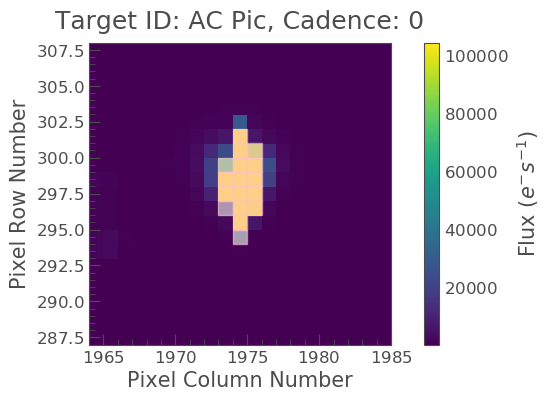

In [8]:
mask = tpf.create_threshold_mask(threshold=500)
tpf.plot(aperture_mask=mask)

In [5]:
lc = tpf.to_lightcurve(aperture_mask=mask)

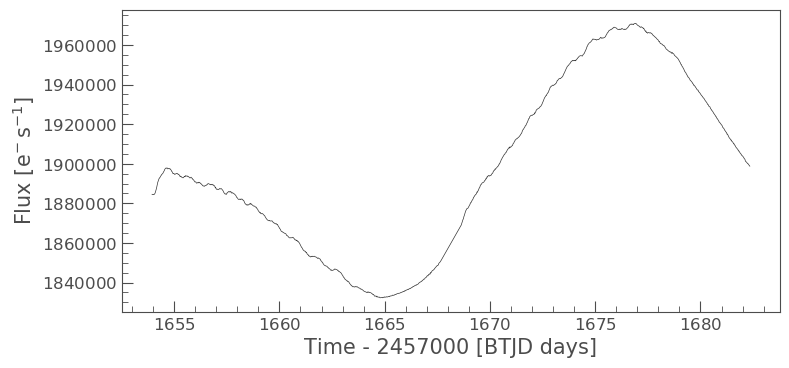

In [6]:
lc.plot()

In [7]:
tpf.interact()

No pixels in `aperture_mask`, finding optimum aperture using `tpf.create_threshold_mask`.


In [9]:
bgmask = ~tpf.create_threshold_mask(threshold=0)

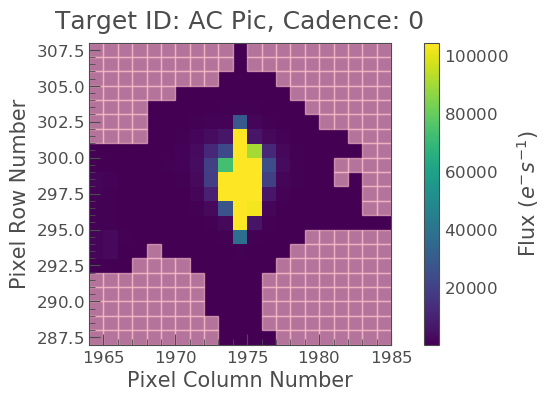

In [10]:
tpf.plot(aperture_mask=bgmask)

In [11]:
regressors = tpf.flux[:, bgmask]

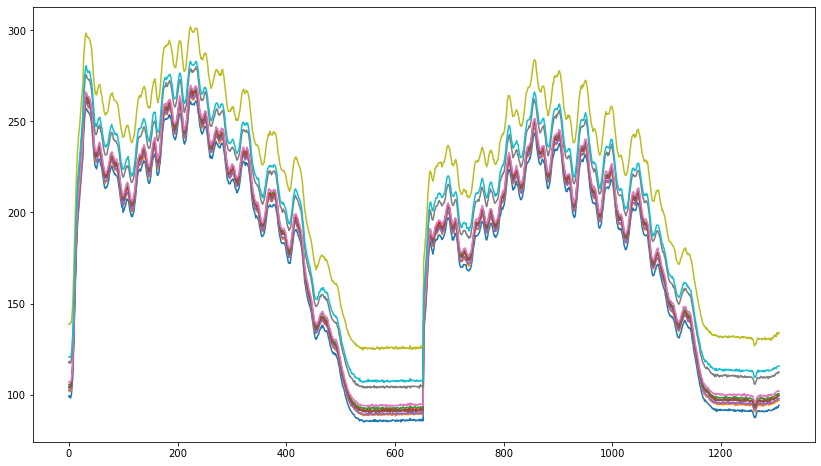

In [13]:
plt.plot(regressors[:, :10]);

In [19]:
dm = lk.DesignMatrix(regressors).pca(3)

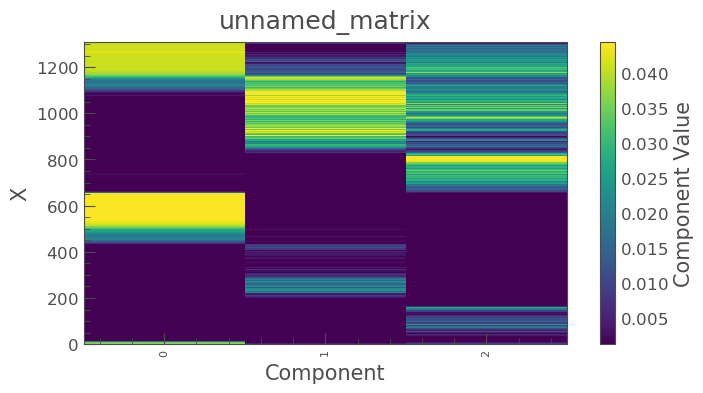

In [20]:
dm.plot()

In [16]:
dm.shape

(1308, 221)

In [21]:
corr = lk.RegressionCorrector(lc)
clc = corr.correct(dm)

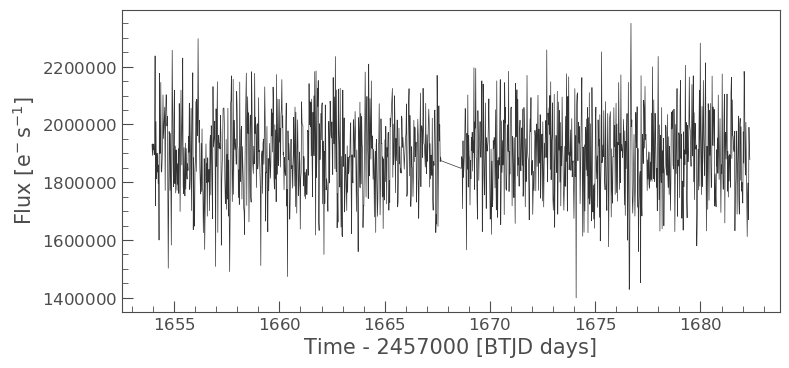

In [18]:
clc.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9787a5b50>,
      dtype=object)

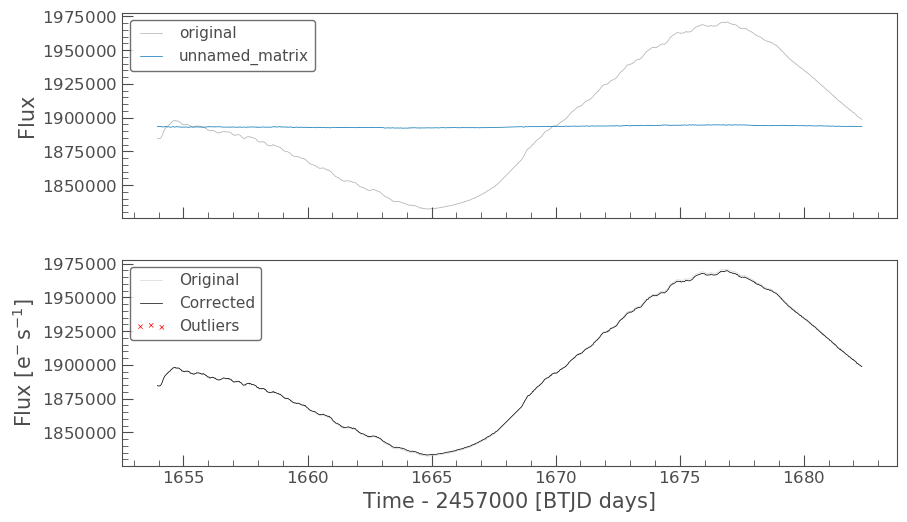

In [22]:
corr.diagnose()

In [23]:
lk.designmatrix.create_spline_matrix(lc.time, n_knots=5, degree=2).plot()

AttributeError: module 'lightkurve.correctors.designmatrix' has no attribute 'create_spline_matrix'

In [32]:
lk.designmatrix.create_spline_matrix()

AttributeError: module 'lightkurve.correctors.designmatrix' has no attribute 'create_spline_matrix'

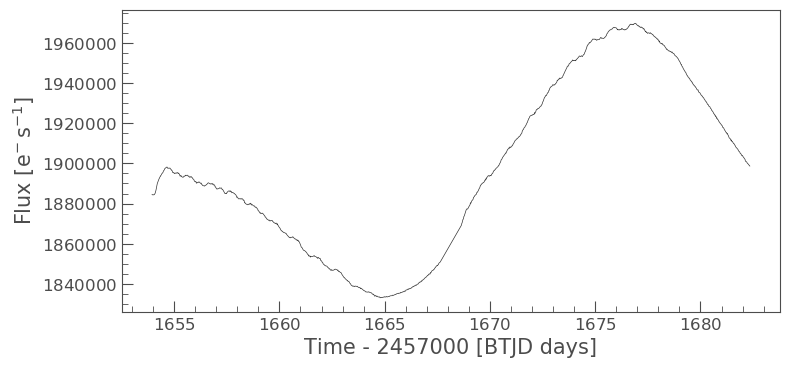

In [26]:
clc.plot()

In [27]:
clc.estimate_cdpp()

329.5534851088622

In [28]:
n_clc = clc.normalize()

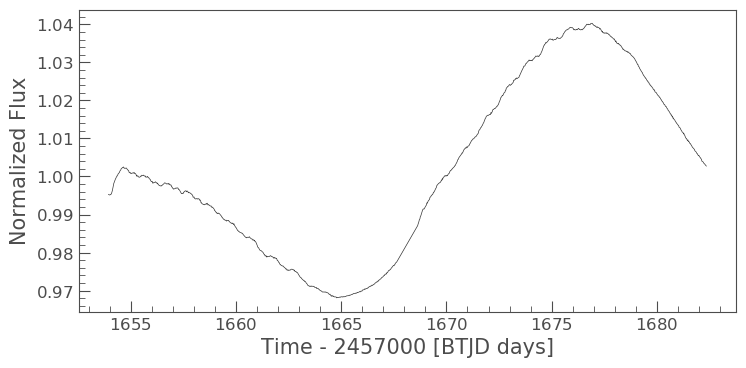

In [29]:
n_clc.plot()

In [30]:
n_clc.estimate_cdpp()

329.5534851091571

AttributeError: 'TessLightCurve' object has no attribute 'FLUX'

In [33]:
pg = n_clc.to_periodogram()

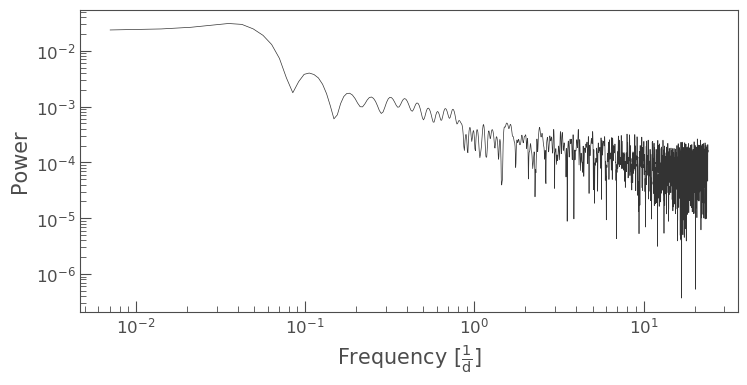

In [34]:
pg.plot(scale="log")

In [35]:
lc.normalize().interact_bls()

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'Slider', 'id': '3408'}, 'attr': 'value', 'new': 0.37}], 'references': []} 
 error: IndexError('index 1900 is out of bounds for axis 0 with size 1871')
Traceback (most recent call last):
  File "/home/soichiro/miniconda3/envs/daily/lib/python3.7/site-packages/bokeh/server/protocol_handler.py", line 100, in handle
    work = yield handler(message, connection)
  File "/home/soichiro/miniconda3/envs/daily/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/home/soichiro/miniconda3/envs/daily/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/soichiro/miniconda3/envs/daily/lib/python3.7/site-packages/bokeh/server/session.py", line 70, in _needs_document_lock_wrapper
    result = yield yield_for_all_futures(func(self, *arg

In [37]:
tpf.interact_sky()